In [3]:
import pandas as pd
import numpy as np
import sys
import os
import bs4
from IPython.display import display_html,clear_output, HTML
import re
from datetime import datetime
import ast
import itertools
from tqdm import tqdm,trange
from file_tools import *
from request_tools import *
from parse_tools import *
from load_tools import *
from model_tools import *
import pyarrow as pa

pd.set_option('display.max_columns', None)
pd.set_option('display.min_rows', 30)
pd.set_option('compute.use_numexpr', False)

import warnings
from pandas.errors import PerformanceWarning
from sklearn.exceptions import DataConversionWarning, ConvergenceWarning
pd.options.mode.use_inf_as_na = True
warnings.filterwarnings('ignore', category=PerformanceWarning)
warnings.filterwarnings('ignore', category=DataConversionWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)

import pandas as pd
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif, RFE, mutual_info_regression
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from scipy.stats import pearsonr
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.svm import SVR


In [25]:
all_labels = pd.read_csv('./07-data-compiled/D0-1523-robust/cumu-bsadv/labels.csv',index_col=[0,1,2],header=[0,1])
labels = all_labels['Match Info']
labels


W/L   Tm  Opp  Pts_Total   
                       index Team_id                                          
/leagues/NBA_2023.html 0     /teams/ATL/2023.html    1  117  107        224  \
                             /teams/BOS/2023.html    1  126  117        243   
                             /teams/BRK/2023.html    0  108  130        238   
                             /teams/CHI/2023.html    1  116  108        224   
                             /teams/CHO/2023.html    1  129  102        231   
                             /teams/CLE/2023.html    0  105  108        213   
                             /teams/DAL/2023.html    0  105  107        212   
                             /teams/DEN/2023.html    0  102  123        225   
                             /teams/DET/2023.html    1  113  109        222   
                             /teams/GSW/2023.html    1  123  109        232   
                             /teams/HOU/2023.html    0  107  117        224   
                             /teams/IND/2023.html    0  107  114        221   
                             /teams/LAC/2023.html    1  103   97        200   
                             /teams/LAL/2023.html    0  109  123        232   
                             /teams/MEM/2023.html    1  115  112        227   
...                                                ...  ...  ...        ...   
/leagues/NBA_2015.html 81    /teams/MIA/2015.html    1  105  101        206   
                             /teams/MIL/2015.html    0  100  105        205   
                             /teams/MIN/2015.html    0  113  138        251   
                             /teams/NOP/2015.html    1  108  103        211   
                             /teams/NYK/2015.html    0   90  112        202   
                             /teams/OKC/2015.html    1  138  113        251   
                             /teams/ORL/2015.html    0   88  101        189   
                             /teams/PHI/2015.html    0  101  105        206   
                             /teams/PHO/2015.html    0  101  112        213   
                             /teams/POR/2015.html    0   98  114        212   
                             /teams/SAC/2015.html    1  122   99        221   
                             /teams/SAS/2015.html    0  103  108        211   
                             /teams/TOR/2015.html    1   92   87        179   
                             /teams/UTA/2015.html    0   91  117        208   
                             /teams/WAS/2015.html    0  108  113        221   

                                                   Pts_Spread  
                       index Team_id                           
/leagues/NBA_2023.html 0     /teams/ATL/2023.html          10  
                             /teams/BOS/2023.html           9  
                             /teams/BRK/2023.html         -22  
                             /teams/CHI/2023.html           8  
                             /teams/CHO/2023.html          27  
                             /teams/CLE/2023.html          -3  
                             /teams/DAL/2023.html          -2  
                             /teams/DEN/2023.html         -21  
                             /teams/DET/2023.html           4  
                             /teams/GSW/2023.html          14  
                             /teams/HOU/2023.html         -10  
                             /teams/IND/2023.html          -7  
                             /teams/LAC/2023.html           6  
                             /teams/LAL/2023.html         -14  
                             /teams/MEM/2023.html           3  
...                                                       ...  
/leagues/NBA_2015.html 81    /teams/MIA/2015.html           4  
                             /teams/MIL/2015.html          -5  
                             /teams/MIN/2015.html         -25  
                             /teams/NOP/2015.html           5  
                             /teams

<Axes: xlabel='Pts_Spread', ylabel='Count'>

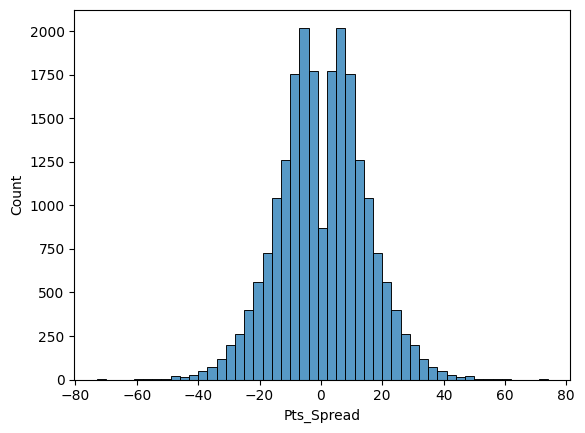

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(labels['Pts_Spread'],binwidth=3)

<Axes: ylabel='Count'>

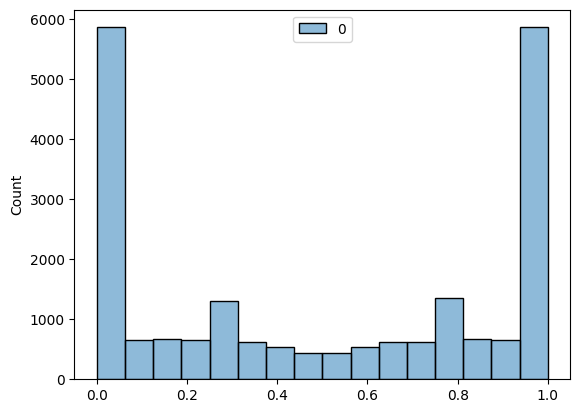

In [26]:
from sklearn.preprocessing import MinMaxScaler


labels_WL_grad = labels['Pts_Spread'].copy()
labels_WL_grad[labels['Pts_Spread'] >= 10] = 10
labels_WL_grad[labels['Pts_Spread'] <= -10] = -10
scaler = MinMaxScaler()
labels_WL_grad = scaler.fit_transform(labels_WL_grad.values.reshape(-1,1))
sns.histplot(labels_WL_grad)

In [30]:
all_labels.loc[:,('Match Info','WL_gradient_pm10')] = labels_WL_grad.round(2)
all_labels

Match Info             
                                                         W/L   Tm  Opp   
                       index Team_id                                     
/leagues/NBA_2023.html 0     /teams/ATL/2023.html          1  117  107  \
                             /teams/BOS/2023.html          1  126  117   
                             /teams/BRK/2023.html          0  108  130   
                             /teams/CHI/2023.html          1  116  108   
                             /teams/CHO/2023.html          1  129  102   
                             /teams/CLE/2023.html          0  105  108   
                             /teams/DAL/2023.html          0  105  107   
                             /teams/DEN/2023.html          0  102  123   
                             /teams/DET/2023.html          1  113  109   
                             /teams/GSW/2023.html          1  123  109   
                             /teams/HOU/2023.html          0  107  117   
                             /teams/IND/2023.html          0  107  114   
                             /teams/LAC/2023.html          1  103   97   
                             /teams/LAL/2023.html          0  109  123   
                             /teams/MEM/2023.html          1  115  112   
...                                                      ...  ...  ...   
/leagues/NBA_2015.html 81    /teams/MIA/2015.html          1  105  101   
                             /teams/MIL/2015.html          0  100  105   
                             /teams/MIN/2015.html          0  113  138   
                             /teams/NOP/2015.html          1  108  103   
                             /teams/NYK/2015.html          0   90  112   
                             /teams/OKC/2015.html          1  138  113   
                             /teams/ORL/2015.html          0   88  101   
                             /teams/PHI/2015.html          0  101  105   
                             /teams/PHO/2015.html          0  101  112   
                             /teams/POR/2015.html          0   98  114   
                             /teams/SAC/2015.html          1  122   99   
                             /teams/SAS/2015.html          0  103  108   
                             /teams/TOR/2015.html          1   92   87   
                             /teams/UTA/2015.html          0   91  117   
                             /teams/WAS/2015.html          0  108  113   

                                                                         
                                                  Pts_Total Pts_Spread   
                       index Team_id                                     
/leagues/NBA_2023.html 0     /teams/ATL/2023.html       224         10  \
                             /teams/BOS/2023.html       243          9   
                             /teams/BRK/2023.html       238        -22   
                             /teams/CHI/2023.html       224          8   
                             /teams/CHO/2023.html       231         27   
                             /teams/CLE/2023.html       213         -3   
                             /teams/DAL/2023.html       212         -2   
                             /teams/DEN/2023.html       225        -21   
                             /teams/DET/2023.html       222          4   
                             /teams/GSW/2023.html       232         14   
                             /teams/HOU/2023.html       224        -10   
                             /teams/IND/2023.html       221         -7   
                             /teams/LAC/2023.html       200          6   
                             /teams/LAL/2023.html       232        -14   
                             /teams/MEM/2023.html       227          3   
...                                                     ...        ...   
/leagues/NBA_2015.html 81    /teams/MIA/2015.html       206          4   
                             /teams/MIL/2015.html    

In [29]:
src_dir = './07-data-compiled/D0-1523-robust'
for folder in get_all_folders(src_dir):
    all_labels.to_csv('/'.join([src_dir,folder,'labels.csv']))

# Predictions

In [15]:
L0_PREDICTIONS = pd.read_csv('./08-experiments/D0-1523-robust/cumu-bsadv/WL_gradient_pm10/20231208-121155/predictions.csv',header=[0,1,2,3,4],index_col=[0,1,2]).droplevel([0,1],axis=1)
# L0_PREDICTIONS = L0_PREDICTIONS[('f_regression','percentile')]
L0_PREDICTIONS

50   
                                                              y_true   
                                                  Unnamed: 3_level_4   
                       index Team_id                                   
/leagues/NBA_2015.html 3     /teams/ATL/2015.html               0.35  \
                             /teams/BOS/2015.html               0.35   
                             /teams/BRK/2015.html               0.15   
                             /teams/CHI/2015.html               0.90   
                             /teams/CHO/2015.html               0.05   
                             /teams/CLE/2015.html               0.40   
                             /teams/DEN/2015.html               0.00   
                             /teams/DET/2015.html               0.65   
                             /teams/GSW/2015.html               1.00   
                             /teams/HOU/2015.html               1.00   
                             /teams/IND/2015.html               0.20   
                             /teams/LAC/2015.html               0.80   
                             /teams/MIA/2015.html               0.00   
                             /teams/MIL/2015.html               0.80   
                             /teams/MIN/2015.html               0.85   
...                                                              ...   
/leagues/NBA_2023.html 81    /teams/MIA/2023.html               1.00   
                             /teams/MIL/2023.html               0.00   
                             /teams/MIN/2023.html               0.75   
                             /teams/NOP/2023.html               0.25   
                             /teams/NYK/2023.html               0.25   
                             /teams/OKC/2023.html               1.00   
                             /teams/ORL/2023.html               0.00   
                             /teams/PHI/2023.html               1.00   
                             /teams/PHO/2023.html               0.25   
                             /teams/POR/2023.html               0.00   
                             /teams/SAC/2023.html               0.00   
                             /teams/SAS/2023.html               1.00   
                             /teams/TOR/2023.html               1.00   
                             /teams/UTA/2023.html               0.00   
                             /teams/WAS/2023.html               0.25   

                                                                                
                                                  AdaBoostRegressor             
                                                                  0         1   
                       index Team_id                                            
/leagues/NBA_2015.html 3     /teams/ATL/2015.html          0.555525  0.401477  \
                             /teams/BOS/2015.html          0.455781  0.565135   
                             /teams/BRK/2015.html          0.673847  0.565135   
                             /teams/CHI/2015.html          0.713862  0.595443   
                             /teams/CHO/2015.html          0.555525  0.401477   
                             /teams/CLE/2015.html          0.567729  0.595443   
                             /teams/DEN/2015.html          0.350219  0.401477   
                             /teams/DET/2015.html          0.430127  0.370201   
                             /teams/GSW/2015.html          0.589399  0.565135   
                             /teams/HOU/2015.html          0.567729  0.707779   
                             /teams/IND/2015.html          0.673847  0.565135   
                             /teams/LAC/2015.html          0.673847  0.565135   
                             /teams/MIA/2015.html          0.589399  0.565135   
                             /teams/MIL/2015.html          0.555525  0.401477   
                             /teams/MIN/2015.html          0.350219  0.401477   
...   

In [16]:
L0_PREDICTIONS_VAL = get_predictions_validation_set(L0_PREDICTIONS)
L0_PREDICTIONS_VAL

y_true                50   
                                                         AdaBoostRegressor   
                       index Team_id                                         
/leagues/NBA_2015.html 3     /teams/ATL/2015.html   0.35          0.345378  \
                             /teams/BOS/2015.html   0.35          0.467809   
                             /teams/BRK/2015.html   0.15          0.632571   
                             /teams/CHI/2015.html   0.90          0.727631   
                             /teams/CHO/2015.html   0.05          0.345378   
                             /teams/CLE/2015.html   0.40          0.345378   
                             /teams/DEN/2015.html   0.00          0.345378   
                             /teams/DET/2015.html   0.65          0.452226   
                             /teams/GSW/2015.html   1.00          0.632571   
                             /teams/HOU/2015.html   1.00          0.703525   
                             /teams/IND/2015.html   0.20          0.467809   
                             /teams/LAC/2015.html   0.80          0.632571   
                             /teams/MIA/2015.html   0.00          0.632571   
                             /teams/MIL/2015.html   0.80          0.345378   
                             /teams/MIN/2015.html   0.85          0.345378   
...                                                  ...               ...   
/leagues/NBA_2023.html 81    /teams/MIA/2023.html   1.00          0.711346   
                             /teams/MIL/2023.html   0.00          0.567729   
                             /teams/MIN/2023.html   0.75          0.673847   
                             /teams/NOP/2023.html   0.25          0.555525   
                             /teams/NYK/2023.html   0.25          0.711346   
                             /teams/OKC/2023.html   1.00          0.452113   
                             /teams/ORL/2023.html   0.00          0.318120   
                             /teams/PHI/2023.html   1.00          0.444000   
                             /teams/PHO/2023.html   0.25          0.605210   
                             /teams/POR/2023.html   0.00          0.411576   
                             /teams/SAC/2023.html   0.00          0.444000   
                             /teams/SAS/2023.html   1.00          0.318120   
                             /teams/TOR/2023.html   1.00          0.455781   
                             /teams/UTA/2023.html   0.00          0.360804   
                             /teams/WAS/2023.html   0.25          0.503688   

                                                                        
                                                  KNeighborsRegressor   
                       index Team_id                                    
/leagues/NBA_2015.html 3     /teams/ATL/2015.html                0.26  \
                             /teams/BOS/2015.html                0.39   
                             /teams/BRK/2015.html                0.61   
                             /teams/CHI/2015.html                0.99   
                             /teams/CHO/2015.html                0.76   
                             /teams/CLE/2015.html                0.25   
                             /teams/DEN/2015.html                0.12   
                             /teams/DET/2015.html                0.60   
                             /teams/GSW/2015.html                0.37   
                             /teams/HOU/2015.html                0.87   
                             /teams/IND/2015.html                0.44   
                             /teams/LAC/2015.html                0.65   
                             /teams/MIA/2015.html                0.43   
                             /teams/MIL/2015.html                0.58   
                             /teams/MIN/2015.html                0.39   
...                                                               ...   
/leagues/N

In [21]:
IDX_DIR = './05-data-indexed'
ALL_IDX_DF = load_all_index_df_of_type(IDX_DIR,idx_type='team_opp_main_index.csv')
ALL_IDX_DF
IDX_DF_L0 = ALL_IDX_DF.loc[L0_PREDICTIONS_VAL.index].droplevel(0,axis=0)
IDX_DF_L0
L0_PREDICTIONS_VAL_TM = L0_PREDICTIONS_VAL.droplevel(0)
L0_PREDICTIONS_VAL_OPP = get_opp_stats_df(L0_PREDICTIONS_VAL_TM,IDX_DF_L0['Opp_Curr_Gm'])
L0_PREDICTIONS_VAL_TM_OPP = pd.concat([L0_PREDICTIONS_VAL_TM,L0_PREDICTIONS_VAL_OPP],keys=['Team','Opp'],axis=1)
L0_LABELS_TM = L0_PREDICTIONS_VAL_TM_OPP.pop(('Team','y_true'))
L0_LABELS_OPP = L0_PREDICTIONS_VAL_TM_OPP.pop(('Opp','y_true'))
L0_PREDICTIONS_VAL_TM_OPP

Team                       
                                          50                       
                           AdaBoostRegressor KNeighborsRegressor   
index Team_id                                                      
3     /teams/ATL/2015.html          0.345378                0.26  \
      /teams/BOS/2015.html          0.467809                0.39   
      /teams/BRK/2015.html          0.632571                0.61   
      /teams/CHI/2015.html          0.727631                0.99   
      /teams/CHO/2015.html          0.345378                0.76   
      /teams/CLE/2015.html          0.345378                0.25   
      /teams/DEN/2015.html          0.345378                0.12   
      /teams/DET/2015.html          0.452226                0.60   
      /teams/GSW/2015.html          0.632571                0.37   
      /teams/HOU/2015.html          0.703525                0.87   
      /teams/IND/2015.html          0.467809                0.44   
      /teams/LAC/2015.html          0.632571                0.65   
      /teams/MIA/2015.html          0.632571                0.43   
      /teams/MIL/2015.html          0.345378                0.58   
      /teams/MIN/2015.html          0.345378                0.39   
...                                      ...                 ...   
81    /teams/MIA/2023.html          0.711346                0.53   
      /teams/MIL/2023.html          0.567729                0.43   
      /teams/MIN/2023.html          0.673847                0.68   
      /teams/NOP/2023.html          0.555525                0.32   
      /teams/NYK/2023.html          0.711346                0.77   
      /teams/OKC/2023.html          0.452113                0.43   
      /teams/ORL/2023.html          0.318120                0.47   
      /teams/PHI/2023.html          0.444000                0.18   
      /teams/PHO/2023.html          0.605210                0.36   
      /teams/POR/2023.html          0.411576                0.15   
      /teams/SAC/2023.html          0.444000                0.50   
      /teams/SAS/2023.html          0.318120                0.09   
      /teams/TOR/2023.html          0.455781                0.35   
      /teams/UTA/2023.html          0.360804                0.44   
      /teams/WAS/2023.html          0.503688                0.27   

                                                           
                                                           
                           LinearRegression MLPRegressor   
index Team_id                                              
3     /teams/ATL/2015.html         0.420649     0.087327  \
      /teams/BOS/2015.html         0.494229     0.328742   
      /teams/BRK/2015.html         0.695030     0.688572   
      /teams/CHI/2015.html         0.806628     0.597975   
      /teams/CHO/2015.html         0.437098     0.500486   
      /teams/CLE/2015.html         0.374630     0.268731   
      /teams/DEN/2015.html         0.476211     0.516330   
      /teams/DET/2015.html         0.535620     0.107983   
      /teams/GSW/2015.html         0.747923     0.541195   
      /teams/HOU/2015.html         0.853812     0.827548   
      /teams/IND/2015.html         0.641531     0.888210   
      /teams/LAC/2015.html         0.650153     0.264169   
      /teams/MIA/2015.html         0.678810     0.820607   
      /teams/MIL/2015.html         0.365452     0.168062   
      /teams/MIN/2015.html         0.340737     0.572031   
...                                     ...          ...   
81    /teams/MIA/2023.html         0.656497     0.668580   
      /teams/MIL/2023.html         0.577819    -0.063581   
      /teams/MIN/2023.html         0.580841     0.820180   
      /teams/NOP/2023.html         0.418868     0.673889   
      /teams/NYK/2023.html         0.724420     1.092750   
      /teams/OKC/2023.html         0.429185     0.312370   
      /teams/ORL/2023.html         0.343495     0.728864   
      /teams/PHI/2023.html         0.48

In [28]:
from sklearn.discriminant_analysis import softmax


# L0_PREDICTIONS_VAL_TM_OPP = L0_PREDICTIONS_VAL_TM_OPP.copy().reorder_levels([1,2,0],axis=1).sort_index(axis=1)
column_indexer = L0_PREDICTIONS_VAL_TM_OPP.columns.droplevel(-1).unique()[0]
L0_PREDICTIONS_VAL_TM_OPP_MODEL = L0_PREDICTIONS_VAL_TM_OPP.loc[:,column_indexer]
# L0_PREDICTIONS_VAL_TM_OPP_MODEL['Diff'] = L0_PREDICTIONS_VAL_TM_OPP_MODEL['Team'] - L0_PREDICTIONS_VAL_TM_OPP_MODEL['Opp']
L0_PREDICTIONS_VAL_TM_OPP_MODEL['softmax'] = softmax(L0_PREDICTIONS_VAL_TM_OPP_MODEL[['Team','Opp']])[:,0]
# L0_PREDICTIONS_VAL_TM_OPP_MODEL['y_pred'] = (L0_PREDICTIONS_VAL_TM_OPP_MODEL['Team'] > L0_PREDICTIONS_VAL_TM_OPP_MODEL['Opp']).astype(int)
L0_PREDICTIONS_VAL_TM_OPP_MODEL['y_true'] = L0_LABELS_TM
L0_PREDICTIONS_VAL_TM_OPP_MODEL

/var/folders/fr/37hzr_m96pl96wysz0n2sxd40000gn/T/ipykernel_65761/1698180656.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  L0_PREDICTIONS_VAL_TM_OPP_MODEL['softmax'] = softmax(L0_PREDICTIONS_VAL_TM_OPP_MODEL[['Team','Opp']])[:,0]
/var/folders/fr/37hzr_m96pl96wysz0n2sxd40000gn/T/ipykernel_65761/1698180656.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  L0_PREDICTIONS_VAL_TM_OPP_MODEL['y_true'] = L0_LABELS_TM


Opp      Team   softmax  y_true
index Team_id                                                   
3     /teams/ATL/2015.html  0.447232  0.324357  0.469320    0.35
      /teams/BOS/2015.html  0.464514  0.447232  0.495680    0.35
      /teams/BRK/2015.html  0.324357  0.626688  0.575012    0.15
      /teams/CHI/2015.html  0.324357  0.708026  0.594758    0.90
      /teams/CHO/2015.html  0.447232  0.324357  0.469320    0.05
      /teams/CLE/2015.html  0.447232  0.585488  0.534509    0.40
      /teams/DEN/2015.html  0.626688  0.324357  0.424988    0.00
      /teams/DET/2015.html  0.585488  0.447232  0.465491    0.65
      /teams/GSW/2015.html  0.464514  0.626688  0.540455    1.00
      /teams/HOU/2015.html  0.447232  0.585488  0.534509    1.00
      /teams/IND/2015.html  0.324357  0.447232  0.530680    0.20
      /teams/LAC/2015.html  0.324357  0.626688  0.575012    0.80
      /teams/MIA/2015.html  0.464514  0.626688  0.540455    0.00
      /teams/MIL/2015.html  0.447232  0.324357  0.469320    0.80
      /teams/MIN/2015.html  0.626688  0.324357  0.424988    0.85
...                              ...       ...       ...     ...
81    /teams/MIA/2023.html  0.268419  0.702205  0.606777    1.00
      /teams/MIL/2023.html  0.535656  0.608854  0.518291    0.00
      /teams/MIN/2023.html  0.415887  0.561693  0.536387    0.75
      /teams/NOP/2023.html  0.561693  0.415887  0.463613    0.25
      /teams/NYK/2023.html  0.268419  0.723073  0.611745    0.25
      /teams/OKC/2023.html  0.608854  0.399025  0.447734    1.00
      /teams/ORL/2023.html  0.702205  0.268419  0.393223    0.00
      /teams/PHI/2023.html  0.535656  0.415887  0.470093    1.00
      /teams/PHO/2023.html  0.399025  0.666812  0.566550    0.25
      /teams/POR/2023.html  0.611558  0.389274  0.444657    0.00
      /teams/SAC/2023.html  0.561693  0.415887  0.463613    0.00
      /teams/SAS/2023.html  0.581773  0.409853  0.457126    1.00
      /teams/TOR/2023.html  0.608854  0.535656  0.481709    1.00
      /teams/UTA/2023.html  0.666812  0.295126  0.408134    0.00
      /teams/WAS/2023.html  0.409853  0.535834  0.531454    0.25

[20638 rows x 4 columns]

In [27]:
softmax(L0_PREDICTIONS_VAL_TM_OPP_MODEL[['Team','Opp']])[:,0]

array([0.46931973, 0.49567974, 0.57501233, ..., 0.4817087 , 0.40813358,
       0.53145355])

<Axes: xlabel="('f_regression', 'percentile', '50', 'Ridge')", ylabel='y_true'>

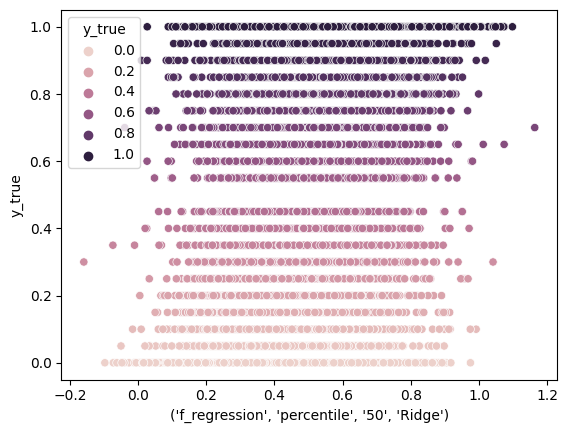

In [12]:
import seaborn as sns
sns.scatterplot(data=L0_PREDICTIONS_VAL,y='y_true',x=L0_PREDICTIONS_VAL.iloc[:,6],hue='y_true')